# Treinamento de Rede Neural com SNR aleatório

## QAM Rayleigh

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf
import sys
sys.path.append('../..')

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from Files_aux.files_01_detection.const_mod import generate_symbols, Model
from Files_aux.files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2023-06-12 16:32:15.154912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-12 16:32:15.154935: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-12 16:32:15.226334: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-12 16:32:16.361091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-12 16:32:16.361194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.4 # Fraction of whole data to be used for training (the remaining is for testing)
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy
Mod = 'QAM'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 16      # PSK modulation

In [3]:
def conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, symb=False, scaler=None):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, [SNR_dB[0]])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)

    if scaler is not None:
        x = scaler(np.concatenate((x, np.array([channel_output[1]]).T), axis=1))
    else:
        x = np.concatenate((x, np.array([channel_output[1]]).T), axis=1)
    
    x = x.reshape(1,-1,3)
    
    for i in range(1, len(SNR_dB)):
        a, b, c = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[i])
        
        d = np.stack([np.real(c[0][:]), np.imag(c[0][:])], axis=1)
        
        if scaler is not None:
            d = scaler(np.concatenate((d, np.array([c[1]]).T), axis=1))
        else:
            d = np.concatenate((d, np.array([c[1]]).T), axis=1)
        
        symbs = np.vstack((symbs, a))
        indices = np.vstack((indices, b))
        channel_output = np.vstack((channel_output, c))
        x = np.vstack((x, d.reshape(1,-1,3)))
    
    y = np.float_(indices)
        
    if symb:
        return x, y, symbs
    else:
        return x, y

In [5]:
def Train_Data(Mod, total_num_symbols, M, channel_type, Es, code_rate, min, max):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, [min, max])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)
    x = np.concatenate((x, np.array([np.real(channel_output[1])]).T), axis=1)
    
    y = np.float_(indices[0])
    
    return x, y, symbs
"""
    indices = np.array([])
    symbs = np.array([])
    channel_output = np.array([])
    alpha = np.array([])
    for i in range(total_num_symbols):
        a, b, c = Model(Mod, 1, M, channel_type, Es, code_rate, np.random.randint(min, max))
        symbs = np.append(symbs, a)
        indices = np.append(indices, b)
        channel_output = np.append(channel_output, c[0])
        alpha = np.append(alpha, c[1])
        
    x = np.stack([np.real(channel_output[:]),
                        np.imag(channel_output[:])], axis=1)
    x = np.concatenate((x, np.array([alpha]).T), axis=1)
    
    y = np.float_(indices)
"""

'\n    indices = np.array([])\n    symbs = np.array([])\n    channel_output = np.array([])\n    alpha = np.array([])\n    for i in range(total_num_symbols):\n        a, b, c = Model(Mod, 1, M, channel_type, Es, code_rate, np.random.randint(min, max))\n        symbs = np.append(symbs, a)\n        indices = np.append(indices, b)\n        channel_output = np.append(channel_output, c[0])\n        alpha = np.append(alpha, c[1])\n        \n    x = np.stack([np.real(channel_output[:]),\n                        np.imag(channel_output[:])], axis=1)\n    x = np.concatenate((x, np.array([alpha]).T), axis=1)\n    \n    y = np.float_(indices)\n'

In [24]:
x_out, y_out, symbs = Train_Data(Mod, total_num_symbols, M, channel_type, Es, code_rate, 5, 30)

In [8]:
x_out = np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1,3))
y_out = np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/y_rand.dat', dtype=np.dtype('float64'))
symbs = np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1,-1))

In [9]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:train_size]
X_train = x_out[:train_size]

# Test
y_test = y_out[train_size:]
X_test = x_out[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


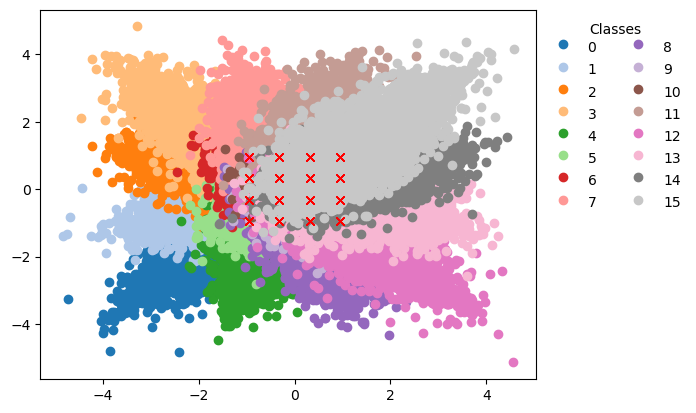

In [7]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [10]:
n_inputs = np.shape(X_train)[1]

In [11]:
n_redes = 3
n_hidden = [[150, 80, 50],
            [300, 180, 90, 40],
            [500, 380, 240, 135, 80]]

n_outputs = M
learning_rate = [0.01, 0.01, 0.001]
n_epochs = [50, 50, 50]
batch_size = [8000, 16000, 24000]
momentum = [0.7, 0.8, 0.9]

In [12]:
y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

2023-03-23 09:43:04.938112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 09:43:04.938216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-23 09:43:04.938294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-23 09:43:04.938370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-23 09:43:04.938446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Usando API Keras

In [13]:
inputs = tf.keras.Input(shape=(n_inputs,))
output = []

for i in range(n_redes):
    x = inputs
    for j in range(len(n_hidden[i])):
        x = tf.keras.layers.Dense(n_hidden[i][j], activation="elu", kernel_initializer="glorot_normal")(x)
    output.append(tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x))
    del x

In [14]:
model_QAM = []
for i in range(n_redes):
    model_QAM.append(tf.keras.Model(inputs=inputs, outputs=output[i]))

    model_QAM[i].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate[i], momentum=momentum[i], nesterov=True),
                 metrics=["accuracy"])

    history = model_QAM[i].fit(X_train, y_train, batch_size=batch_size[i], epochs=n_epochs[i], shuffle=True)

    tests_score = model_QAM[i].evaluate(X_test, y_test)
    print("\nTest loss:", tests_score[0])
    print("Test accuracy:", tests_score[1])
    print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

Epoch 1/50
50/50 [==============================] - 1s 16ms/step - loss: 2.4186 - accuracy: 0.2396
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 1.9609 - accuracy: 0.3711
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 1.6823 - accuracy: 0.4730
Epoch 4/50
50/50 [==============================] - 1s 16ms/step - loss: 1.5180 - accuracy: 0.5243
Epoch 5/50
50/50 [==============================] - 1s 16ms/step - loss: 1.4130 - accuracy: 0.5569
Epoch 6/50
50/50 [==============================] - 1s 15ms/step - loss: 1.3385 - accuracy: 0.5828
Epoch 7/50
50/50 [==============================] - 1s 17ms/step - loss: 1.2806 - accuracy: 0.6015
Epoch 8/50
50/50 [==============================] - 1s 15ms/step - loss: 1.2340 - accuracy: 0.6147
Epoch 9/50
50/50 [==============================] - 1s 15ms/step - loss: 1.1969 - accuracy: 0.6219
Epoch 10/50
50/50 [==============================] - 1s 15ms/step - loss: 1.1683 - accuracy: 0.6269
Epoch 11/

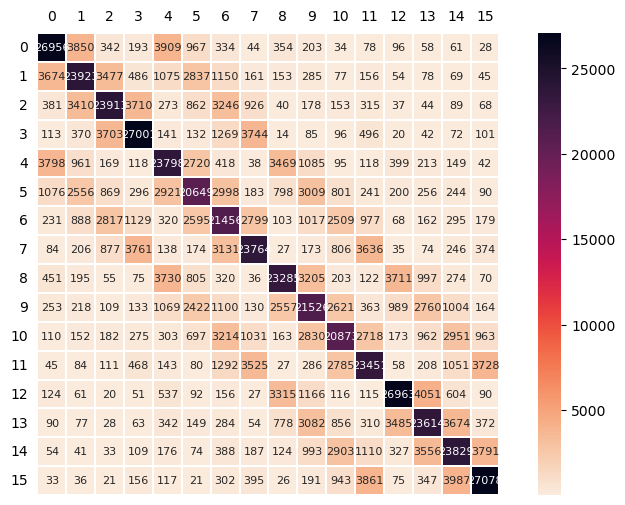

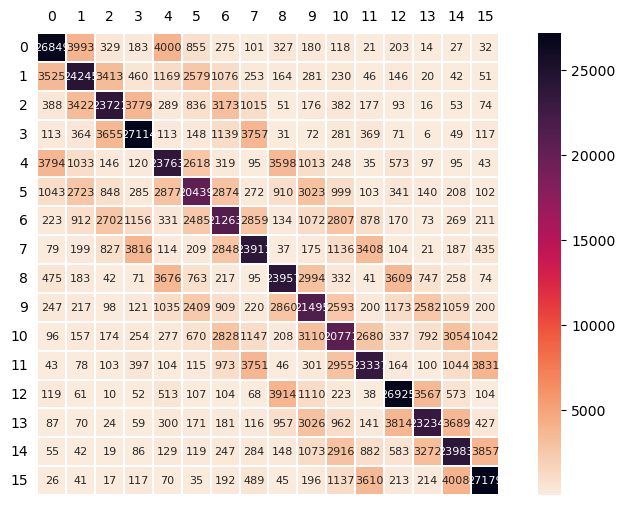

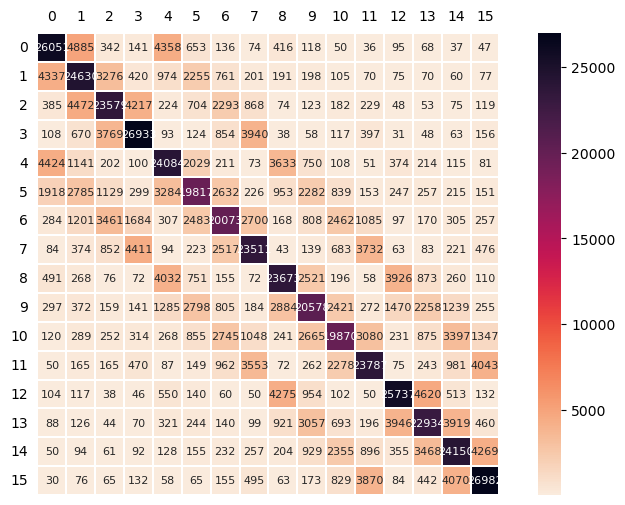

In [15]:
for i in range(n_redes):
    plot_confusion_matrix(model_QAM[i], X_test, y_test, M, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | Rayleigh

In [16]:
Mod = "QAM"
channel_type = "rayleigh"
M = 16
init_scale = 2
interval = 18
passo = 1

In [17]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [18]:
amostras = [conjunto(Mod, int(200 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [19]:
error_rate = ([[ser(model_QAM[j], tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))] for j in range(n_redes)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [20]:
error_rate

<tf.Tensor: shape=(3, 18), dtype=float32, numpy=
array([[0.16587678, 0.1711111 , 0.1587137 , 0.14655173, 0.13596492,
        0.12142857, 0.12144887, 0.11369347, 0.08076923, 0.08079848,
        0.06881107, 0.0537931 , 0.04253472, 0.04431599, 0.03798727,
        0.02886497, 0.02513298, 0.02169689],
       [0.16232227, 0.16888888, 0.15767635, 0.14559387, 0.13508771,
        0.12142857, 0.12073863, 0.1143216 , 0.08296704, 0.07984791,
        0.06840391, 0.05448276, 0.04253472, 0.0438343 , 0.03818616,
        0.02674494, 0.02353723, 0.02169689],
       [0.16587678, 0.16888888, 0.15663901, 0.14176245, 0.14035088,
        0.12539683, 0.11931818, 0.11180905, 0.08571429, 0.08222433,
        0.0745114 , 0.05586207, 0.04513889, 0.04359345, 0.03560064,
        0.02902805, 0.02446808, 0.02061744]], dtype=float32)>

In [21]:
np.mean(error_rate - Teo_SNRs)

-0.023361286

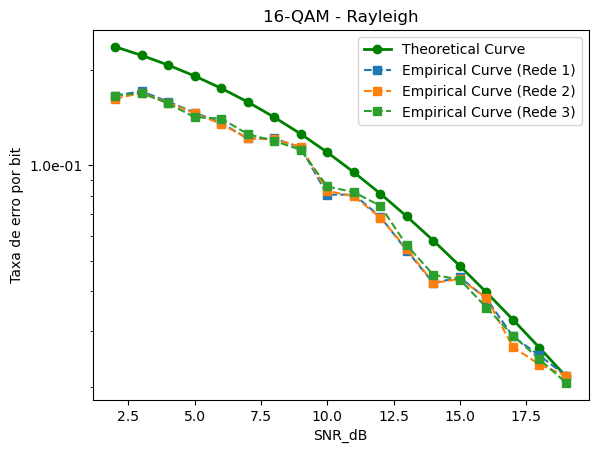

In [22]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
[ax.plot(x, error_rate[i], 's--', label=f'Empirical Curve (Rede {i + 1})') for i in range(n_redes)]

ax.set_title('16-QAM - Rayleigh')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

## QAM AWGN

In [2]:
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.7 # Fraction of whole data to be used for training (the remaining is for testing)
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy
Mod = 'QAM'
channel_type = 'awng' # 'awgn' or 'crazy'
M            = 16      # PSK modulation

In [3]:
x_out = np.fromfile('Random_Data/SNR_8-12/AWGN/16-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1,3))
y_out = np.fromfile('Random_Data/SNR_8-12/AWGN/16-QAM/y_rand.dat', dtype=np.dtype('float64'))
symbs = np.fromfile('Random_Data/SNR_8-12/AWGN/16-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1,-1))

In [4]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:train_size]
X_train = x_out[:train_size]

# Test
y_test = y_out[train_size:]
X_test = x_out[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


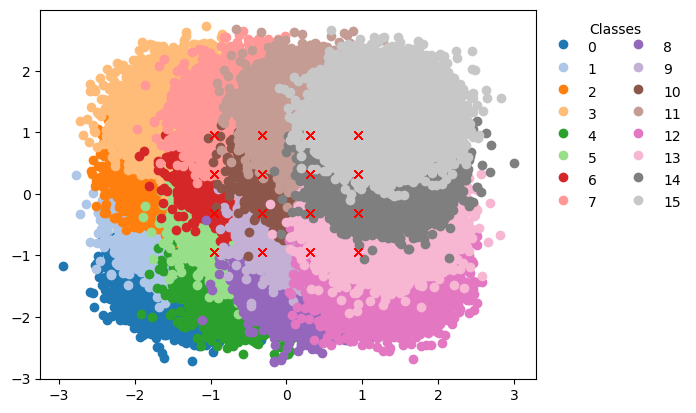

In [5]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [9]:
n_inputs = np.shape(X_train)[1]

In [10]:
n_redes = 3
n_hidden = [[150, 80, 50],
            [300, 180, 90, 40],
            [500, 380, 240, 135, 80]]

n_outputs = M
learning_rate = [0.01, 0.01, 0.001]
n_epochs = [50, 50, 50]
batch_size = [8000, 16000, 24000]
momentum = [0.7, 0.8, 0.9]

In [11]:
y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

2023-04-10 10:59:29.432444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-10 10:59:29.433209: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-10 10:59:29.433270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keko-ubuntu): /proc/driver/nvidia/version does not exist
2023-04-10 10:59:29.439783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Usando API Keras

In [12]:
inputs = tf.keras.Input(shape=(n_inputs,))
output = []

for i in range(n_redes):
    x = inputs
    for j in range(len(n_hidden[i])):
        x = tf.keras.layers.Dense(n_hidden[i][j], activation="elu", kernel_initializer="glorot_normal")(x)
    output.append(tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x))
    del x

In [13]:
model_QAM = []
for i in range(n_redes):
    model_QAM.append(tf.keras.Model(inputs=inputs, outputs=output[i]))
    
    model_QAM[i].summary()

    model_QAM[i].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate[i], momentum=momentum[i], nesterov=True),
                 metrics=["accuracy"])

    history = model_QAM[i].fit(X_train, y_train, batch_size=batch_size[i], epochs=n_epochs[i], shuffle=True)

    tests_score = model_QAM[i].evaluate(X_test, y_test)
    print("\nTest loss:", tests_score[0])
    print("Test accuracy:", tests_score[1])
    print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 150)               600       
                                                                 
 dense_1 (Dense)             (None, 80)                12080     
                                                                 
 dense_2 (Dense)             (None, 50)                4050      
                                                                 
 dense_3 (Dense)             (None, 16)                816       
                                                                 
Total params: 17,546
Trainable params: 17,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
88/88 [==============================] - 3s 22

2023-04-10 11:07:18.979053: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.
2023-04-10 11:07:19.019261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36480000 exceeds 10% of free system memory.
2023-04-10 11:07:19.211198: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36480000 exceeds 10% of free system memory.
2023-04-10 11:07:19.274379: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.


 1/30 [>.............................] - ETA: 32s - loss: 2.7192 - accuracy: 0.0950

2023-04-10 11:07:19.499401: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.


30/30 [==============================] - 16s 518ms/step - loss: 2.6255 - accuracy: 0.1369
Epoch 2/50
30/30 [==============================] - 16s 540ms/step - loss: 2.3712 - accuracy: 0.2975
Epoch 3/50
30/30 [==============================] - 17s 553ms/step - loss: 2.1420 - accuracy: 0.3309
Epoch 4/50
30/30 [==============================] - 18s 585ms/step - loss: 1.9374 - accuracy: 0.3716
Epoch 5/50
30/30 [==============================] - 17s 564ms/step - loss: 1.7612 - accuracy: 0.4274
Epoch 6/50
30/30 [==============================] - 17s 571ms/step - loss: 1.6160 - accuracy: 0.5069
Epoch 7/50
30/30 [==============================] - 18s 589ms/step - loss: 1.4981 - accuracy: 0.5513
Epoch 8/50
30/30 [==============================] - 17s 574ms/step - loss: 1.4009 - accuracy: 0.5774
Epoch 9/50
30/30 [==============================] - 17s 572ms/step - loss: 1.3184 - accuracy: 0.6004
Epoch 10/50
30/30 [==============================] - 17s 581ms/step - loss: 1.2470 - accuracy: 0.6225


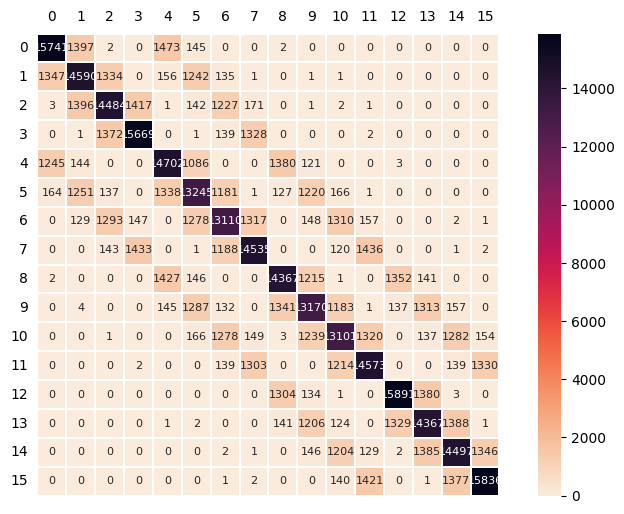

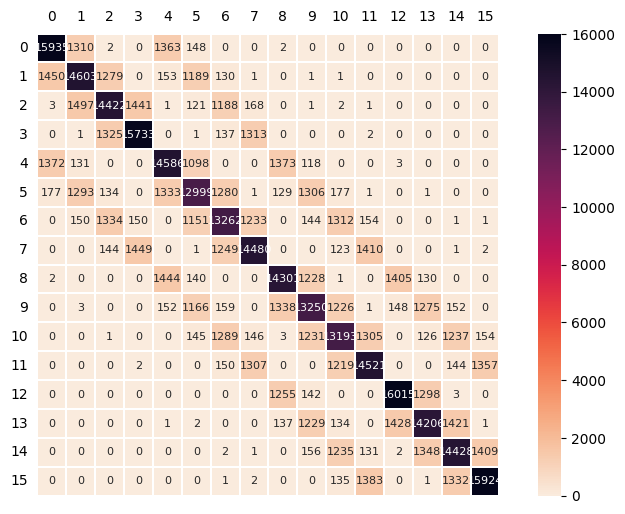

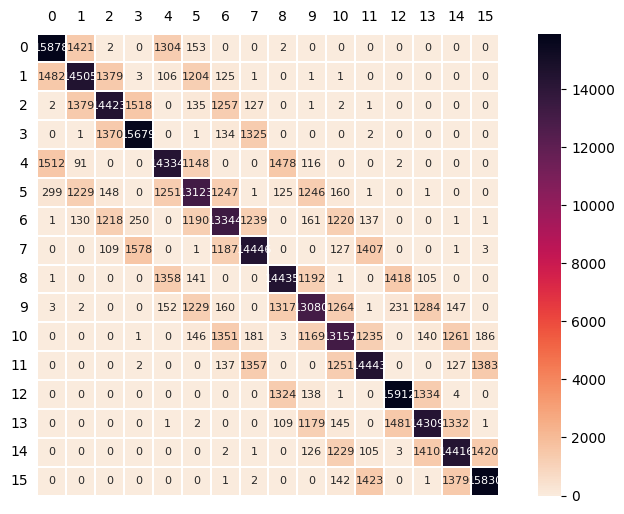

In [14]:
for i in range(n_redes):
    plot_confusion_matrix(model_QAM[i], X_test, y_test, M, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | AWGN

In [26]:
Mod = "QAM"
channel_type = "awgn"
M = 16
init_scale = 2
interval = 28
passo = 1

In [27]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [17]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [ ]:
error_rate = ([[error(int(100 / (Teo_SNRs[int(i / passo)] * np.log2(M))), model_QAM[j], Mod, M, channel_type, Es, code_rate, [init_scale + i]) for i in range(0, interval, passo)] for j in range(n_redes)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [18]:
error_rate = ([[ser(model_QAM[j], tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))] for j in range(n_redes)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [ ]:
error_rate

In [20]:
np.mean(error_rate - Teo_SNRs)

-0.002495486

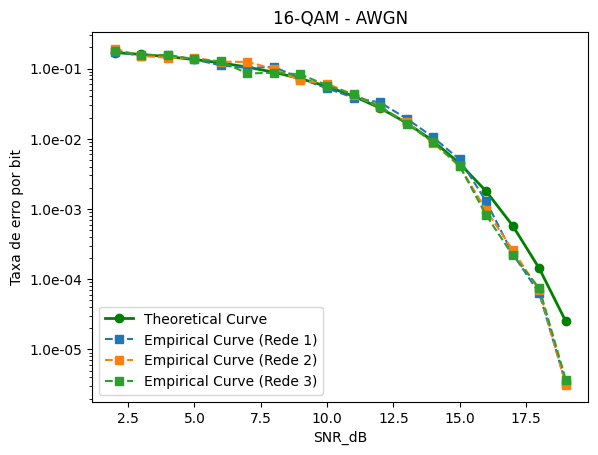

In [25]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
[ax.plot(x, error_rate[i], 's--', label=f'Empirical Curve (Rede {i + 1})') for i in range(n_redes)]

ax.set_title('16-QAM - AWGN')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()